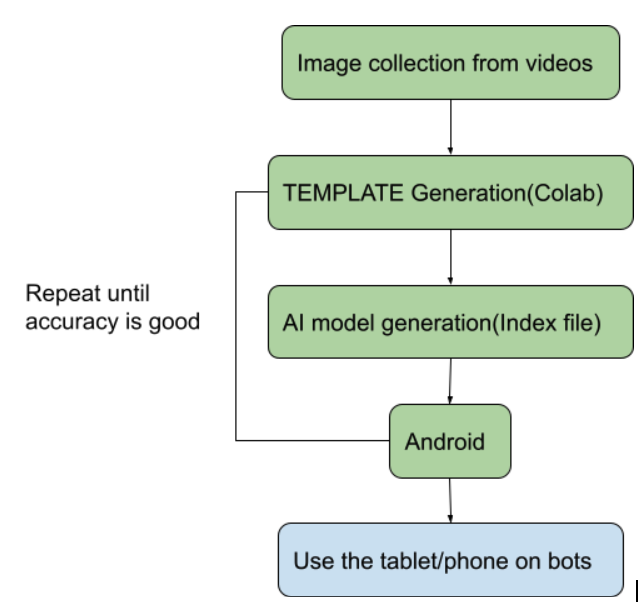


# **Design Solution**

*Given :*

1. 1.66 - 48 inch in diameter
2. 30-60 feet long
3. Stacked in 3 - 20 layers depending on Outside Diameter size (but not higher than approx. 10Feet)
4. More than 1 thousand pipes in 1 acre
5. A tag and/or cap may be attached to the end of the tube
6. In the case of large diameter pipes, the pipe stacks are often several hundred meters long and the distance between the stacks is often so narrow that it can be difficult to take a picture from the front.
7. Since each pipe weighs up to several tons, it is difficult to calculate the number of pipes by weighing them all at once.

*Actions :*

1. Variable diameter is taken in solution for feature detection
2. Side view will be not be the best view
3. Stacks are not too high, so view will be landscape
4. Manual collection of images is not possible
5. Extra features need to be considered in solution
6. Considered at 3.
7. Weighing them is not considered.





**Workflow**
1. Land vehicle robots to collect recordings of a particular stack.

2. Recording to done in one direction, only front of stack will be neccessary.  

2. Only one stack of pipes should be taken for each recording.

2. Take the key frames from each part of recording.(Where the pipe front is visible, at least 10 images for each recording)

2. Develop templates of each pipe: Circular region template, With tag or cap  template.

2. Identify each count of each image in the scene by putting a number.

2. Now keep adding count as the video runs in one direction.

2. *For new recording if, the old templates can be used then the accuracy of model increases over time*





**TEMPLATE DEVELOPMENT**

1. Hough Circles are taken to identify pipe circular structure and templates are saved.

2. Manual crops of pipe with tags and caps should taken by human in loop.

3. Choose a template according to a part of image (very important)


**AI MODEL DEVELOPMENT**

1. Use the templates to train a feature generation model

2. Use the old database created from other videos, if type of pipes are same.

2. Once trained, model is tested on validation data for more images

3. If validation accuracy is good, then pass the model to deployment module


**AI MODEL DEPLOYMENT**

1. Android app will be used
2. The template used earlier will be detected multiple times in the view
2. The app will keep a count of current view, and keep adding it as the phone moves in a single direction
3. Use of the app in the land robot in future for more ease of use. 

# TEMPLATE DEVELOPMENT


Choose the thresholds of radius and distance between circles in your image and the count of pipes will be detected by cv2 package. 

If the count is incorrect: 
1. Try changing the thresholds
2. Choose a new image from the video
3. Or move on to manual template generation

Count: 48


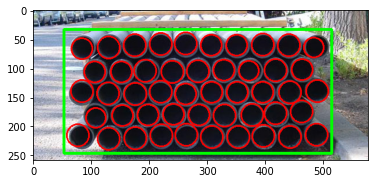

In [4]:
import requests
import numpy as np
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_URL = 'https://robertkaplinsky.com/wp-content/uploads/2013/09/water_pipes_cover1.jpg'  #@param {type:"string"} ['https://robertkaplinsky.com/wp-content/uploads/2013/09/water_pipes_cover1.jpg', 'https://previews.123rf.com/images/merzavka/merzavka1103/merzavka110300092/9184111-new-steel-pipes-for-gas-pipeline-in-the-shape-of-a-pyramid-stacked-at-warehouse.jpg']
MIN_RADIUS = 15  # @param {type:"integer"}
MAX_RADIUS = 20  # @param {type:"integer"}
MIN_DIST = 28  # @param {type:"integer"}
GENERATE_TEMPLATES = True  # @param {type:"boolean"}
IMAGE_NO = 1 # @param {type:"integer"}


def url_to_img(url, save_as='/content/'+str(IMAGE_NO)+'.jpg'):
  img = Image.open(BytesIO(requests.get(url).content))
  if save_as:
    img.save(save_as)
  return np.array(img)


def run_basic(url):
  
  image = url_to_img(url)
  blur_hor = cv2.filter2D(image[:, :, 0], cv2.CV_32F, kernel=np.ones((11,1,1), np.float32)/11.0, borderType=cv2.BORDER_CONSTANT)
  blur_vert = cv2.filter2D(image[:, :, 0], cv2.CV_32F, kernel=np.ones((1,11,1), np.float32)/11.0, borderType=cv2.BORDER_CONSTANT)
  mask = ((image[:,:,0]>blur_hor*1.2) | (image[:,:,0]>blur_vert*1.2)).astype(np.uint8)*255

  circles = cv2.HoughCircles(mask,
                            cv2.HOUGH_GRADIENT,
                            minDist = MIN_DIST,
                            dp=1,
                            param1=150,
                            param2=12,
                            minRadius = MIN_RADIUS,
                            maxRadius = MAX_RADIUS)
  output = image.copy()
  final_output = image.copy()

  count = 0
  for (x, y, r) in circles[0, :, :]:
    cv2.circle(output, (int(x), int(y)), int(r), (255, 0, 0), 2)
    # cv2.circle(output, (int(x), int(y)), int(r)+5, (0, 0, 255), 2)

    count = count + 1
  
  if GENERATE_TEMPLATES:
    height,width,_ = image.shape
    mask = np.zeros((height,width), np.uint8)
    idx = 0
    boxes = []
    for (x, y, r) in circles[0, :, :]:
      cv2.circle(mask, (int(x), int(y)), int(r)+5, (255, 255, 255), -1)
      masked_data = cv2.bitwise_and(image, image, mask=mask)
      # Apply Threshold
      _,thresh = cv2.threshold(mask,1,255,cv2.THRESH_BINARY)

      # Find Contour
      contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2:]
      # print(contours[0])
      x,y,w,h = cv2.boundingRect(contours[0])
      boxes.append([x,y, x+w,y+h])

      # Crop masked_data
      # crop = masked_data[y:y+h,x:x+w]
      # !mkdir -p templates
      # cv2.imwrite('/content/templates/template'+str(IMAGE_NO)+str(idx)+'.jpg',crop)
      idx = idx + 1
    boxes = np.asarray(boxes)
    left, top = np.min(boxes, axis=0)[:2]
    right, bottom = np.max(boxes, axis=0)[2:]

    cv2.rectangle(output, (left,top), (right,bottom), (0, 255, 0), 3)
    crop = final_output[top:bottom,left:right]
    cv2.imwrite('/content/template_'+str(count)+"_"+str(IMAGE_NO)+'.jpg',crop)
  

  print('Count: {}'.format(count))
  plt.imshow(output)
  # plt.imshow(mask)
  



image_url = IMAGE_URL
run_basic(image_url)

# Or choose a manual template

Choose the boundary of your image and enter the count of pipes in that boundary

Count: 5


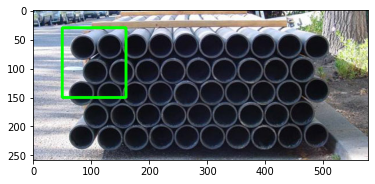

In [7]:
import requests
import numpy as np
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_URL = 'https://robertkaplinsky.com/wp-content/uploads/2013/09/water_pipes_cover1.jpg'  #@param {type:"string"} ['https://robertkaplinsky.com/wp-content/uploads/2013/09/water_pipes_cover1.jpg', 'https://previews.123rf.com/images/merzavka/merzavka1103/merzavka110300092/9184111-new-steel-pipes-for-gas-pipeline-in-the-shape-of-a-pyramid-stacked-at-warehouse.jpg']
LEFT = 50  # @param {type:"integer"}
TOP = 30  # @param {type:"integer"}
RIGHT = 160  # @param {type:"integer"}
BOTTOM = 150  # @param {type:"integer"}
GENERATE_TEMPLATES = False  # @param {type:"boolean"}
IMAGE_NO = 1 # @param {type:"integer"}
COUNT = 7 # @param {type:"integer"}

def url_to_img(url, save_as='/content/'+str(IMAGE_NO)+'.jpg'):
  img = Image.open(BytesIO(requests.get(url).content))
  if save_as:
    img.save(save_as)
  return np.array(img)


def run_basic(url):
  
  image = url_to_img(url)
  output = image.copy()
  final_output = image.copy()

  cv2.rectangle(output, (LEFT,TOP), (RIGHT,BOTTOM), (0, 255, 0), 3)
  if GENERATE_TEMPLATES:
    left, top = np.min(boxes, axis=0)[:2]
    right, bottom = np.max(boxes, axis=0)[2:]

    crop = final_output[top:bottom,left:right]
    cv2.imwrite('/content/template_'+str(count)+"_"+str(IMAGE_NO)+'.jpg',crop)
  

  print('Count: {}'.format(COUNT))
  plt.imshow(output)
  # plt.imshow(mask)
  



image_url = IMAGE_URL
run_basic(image_url)

Save the template image

Open Files->Choose the "template_***"->Download